# Heart Attack Study
By Kai C, Nathaniel G, Josiah L, Joseph T

## Data Preprocessing

Since the dataset file is too large, we will download the csv file (https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states) and keep it in the downloads folder.

We will then import pandas and read the csv file and convert it into a dataframe.

### Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Read CSV file:

In [2]:
heart_attack_df = pd.read_csv('~/Downloads/heart_attack_dataset.csv')

### Remove Rows with NULL values:

In [3]:
heart_attack_df = heart_attack_df.dropna()

print("Rows: " + str(len(heart_attack_df.index)))


Rows: 372974


### Parsing:

Reassigned the value 1 to True and value 0 to False for the Smoker, Diabetes, Hypertension, FamilyHistory, PreviousHeartAttack, and StrokeHistory columns.

In [4]:
heart_attack_df['Smoker'] = heart_attack_df['Smoker'].apply(lambda value : True if value == 1 else False)
heart_attack_df['Diabetes'] = heart_attack_df['Diabetes'].apply(lambda value : True if value == 1 else False)
heart_attack_df['Hypertension'] = heart_attack_df['Hypertension'].apply(lambda value : True if value == 1 else False)
heart_attack_df['FamilyHistory'] = heart_attack_df['FamilyHistory'].apply(lambda value : True if value == 1 else False)
heart_attack_df['PreviousHeartAttack'] = heart_attack_df['PreviousHeartAttack'].apply(lambda value : True if value == 1 else False)
heart_attack_df['StrokeHistory'] = heart_attack_df['StrokeHistory'].apply(lambda value : True if value == 1 else False)

heart_attack_df.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,ExerciseInducedAngina,Slope,NumberOfMajorVessels,Thalassemia,PreviousHeartAttack,StrokeHistory,Residence,EmploymentStatus,MaritalStatus,Outcome
0,31,Male,194,162,71,22.9,False,True,False,False,...,Yes,Downsloping,1,Normal,False,False,Suburban,Retired,Single,No Heart Attack
1,69,Male,208,148,93,33.9,True,True,False,False,...,Yes,Upsloping,2,Normal,False,False,Suburban,Unemployed,Married,No Heart Attack
2,34,Female,132,161,94,34.0,False,False,True,True,...,Yes,Upsloping,0,Normal,True,False,Rural,Retired,Single,Heart Attack
3,53,Male,268,134,91,35.0,False,True,True,False,...,Yes,Flat,0,Reversible defect,True,False,Suburban,Retired,Widowed,No Heart Attack
4,57,Female,203,140,75,30.1,False,True,False,False,...,Yes,Flat,0,Fixed defect,True,False,Rural,Retired,Married,Heart Attack


## Conclusion 1
By Joseph

## Conclusion 2
By Josiah

Text(158.08159722222223, 0.5, 'Numerical Columns')

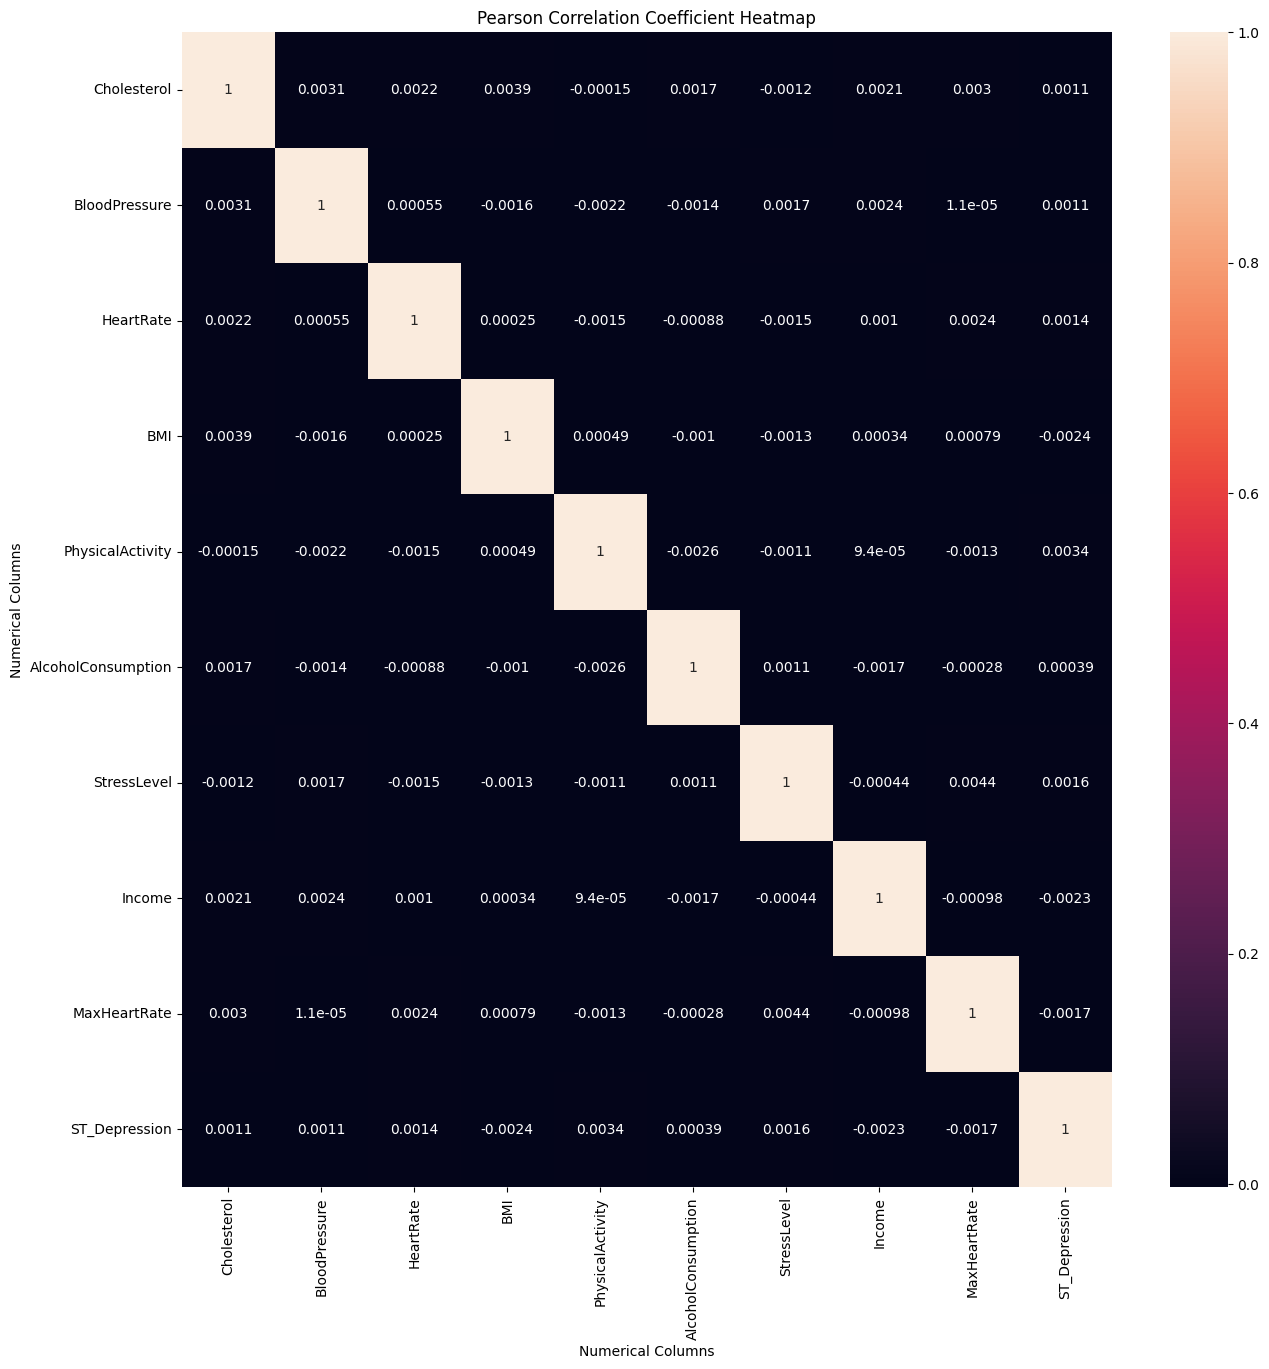

In [5]:
plt.figure(figsize=(15, 15))

heart_attack_df_correlation = heart_attack_df[['Cholesterol', 'BloodPressure', 'HeartRate', 'BMI', 'PhysicalActivity', 'AlcoholConsumption', 'StressLevel', 'Income', 'MaxHeartRate', 'ST_Depression']]

sns.heatmap(heart_attack_df_correlation.corr(method='pearson'), annot=True)

plt.title("Pearson Correlation Coefficient Heatmap")
plt.xlabel("Numerical Columns")
plt.ylabel("Numerical Columns")

From the results of the heatmap, there doesn't seem to be a linear relationship between any of the numerical columns since the Pearson correlation coefficient values are close to 0.

## Conclusion 3
By Nathaniel

Conducting a hypothesis test to determine whether or not level of cholesterol has an effect on the outcome of a heart attack. 

For the purposes of this test,  I will assume the population standard deviation is unknown. Therefore I will use a two-sample T-test with level of significance $\alpha=0.05$.

- H0: Level of cholesterol does not have an effect on the outcome of whether a heart attack occured
- HA: Level of cholesterol does have an effect on the outcome of whether a heart attack occured.

To conduct this test, the data is split into two samples based on whether or not cholesterol is above the mean of the sample:

In [ ]:
#convert object type data to numeric for stats.ttest_ind()
heart_attack_df['outcome_numeric'] = heart_attack_df['Outcome'].map({'No Heart Attack': 0, 'Heart Attack': 1})

mean = heart_attack_df['Cholesterol'].mean()

low_col_df = heart_attack_df[heart_attack_df['Cholesterol'] < mean]['outcome_numeric']
high_col_df = heart_attack_df[heart_attack_df['Cholesterol'] >= mean]['outcome_numeric']

0         0
2         1
5         1
9         0
10        1
         ..
372962    1
372966    0
372968    1
372970    1
372973    1
Name: outcome_numeric, Length: 186602, dtype: int64

In [35]:
t_stat, p_value = scipy.stats.ttest_ind(low_col_df, high_col_df, equal_var=False) 
p_value

np.float64(0.13103144828583682)

The p-value (0.131) >= 0.05, indicates no significant difference between the groups. We fail to reject the null hypothesis.

C:\Users\natha\AppData\Local\Temp\ipykernel_31648\2552999534.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="Cholesterol", data=heart_attack_df, palette="Set2")


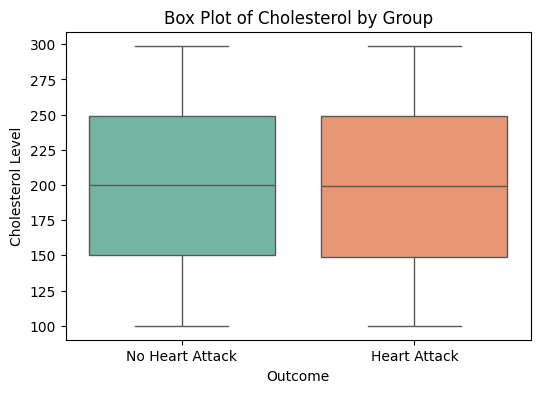

In [43]:
plt.figure(figsize=(6, 4))
plt.xlabel("Outcome")
plt.ylabel("Cholesterol Level")
plt.title("Box Plot of Cholesterol by Group")
sns.boxplot(x="Outcome", y="Cholesterol", data=heart_attack_df, palette="Set2")

plt.show()

(There appears to be little difference in the summary statistics for these two groups, thus resulting in the similar boxplots)

In [44]:
print(heart_attack_df.groupby("Outcome")["Cholesterol"].describe())

                    count        mean        std    min    25%    50%    75%  \
Outcome                                                                        
Heart Attack     186316.0  199.342504  57.758458  100.0  149.0  199.0  249.0   
No Heart Attack  186658.0  199.568976  57.688280  100.0  150.0  200.0  249.0   

                   max  
Outcome                 
Heart Attack     299.0  
No Heart Attack  299.0  


C:\Users\natha\AppData\Local\Temp\ipykernel_31648\951730545.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette="Set2")


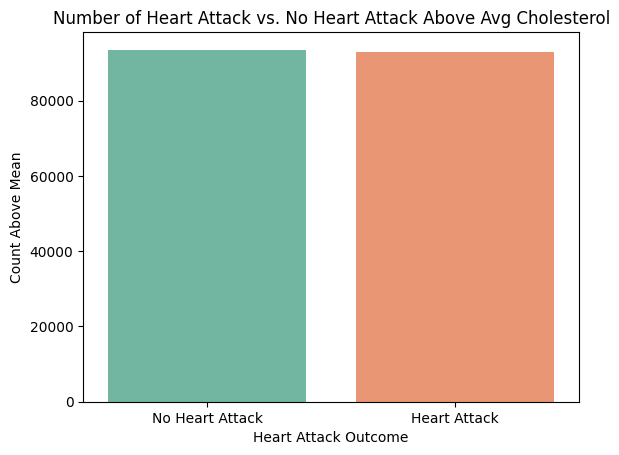

Outcome
No Heart Attack    93502
Heart Attack       92870
Name: count, dtype: int64

In [49]:
above_mean_df = heart_attack_df[heart_attack_df['Cholesterol'] > mean]

group_counts = above_mean_df['Outcome'].value_counts()

sns.barplot(x=group_counts.index, y=group_counts.values, palette="Set2")

plt.xlabel("Heart Attack Outcome")
plt.ylabel("Count Above Mean")
plt.title("Number of Heart Attack vs. No Heart Attack Above Avg Cholesterol")

plt.show()
group_counts

## Conclusion 4 (extra)
By Kai

I will write a new hypothesis test based on four categorical variables, thus, I will be using ANOVA tests.

The following is a hypothesis test for whether the marital status has an effect on the outcome of a heart attack. (Assume $\alpha=0.05$).

- HO: The marital status does not have an effect on the outcome of whether one has a heart attack (i.e., they're independent).

- HA: The martial status does have an effect on the outcome of whether one has a heart attack.

I will first split the data into 4 different dataframes based on marital status.

In [26]:
# to tell me what the categorical variables were
# heart_attack_df['MaritalStatus'].unique()

single = heart_attack_df['MaritalStatus'] == 'Single'
married = heart_attack_df['MaritalStatus'] == 'Married'
widowed = heart_attack_df['MaritalStatus'] == 'Widowed'
divorced = heart_attack_df['MaritalStatus'] == 'Divorced'

# store the proportions of 'No Heart Attack' and 'Heart Attack'
single_proportion = heart_attack_df[single]['Outcome'].value_counts(normalize=True)
married_proportion = heart_attack_df[married]['Outcome'].value_counts(normalize=True)
widowed_proportion = heart_attack_df[widowed]['Outcome'].value_counts(normalize=True)
divorced_proportion = heart_attack_df[divorced]['Outcome'].value_counts(normalize=True)

display([single_proportion, married_proportion, widowed_proportion, divorced_proportion])

[Outcome
 No Heart Attack    0.500347
 Heart Attack       0.499653
 Name: proportion, dtype: float64,
 Outcome
 Heart Attack       0.500894
 No Heart Attack    0.499106
 Name: proportion, dtype: float64,
 Outcome
 No Heart Attack    0.501075
 Heart Attack       0.498925
 Name: proportion, dtype: float64,
 Outcome
 No Heart Attack    0.5013
 Heart Attack       0.4987
 Name: proportion, dtype: float64]

Next, I will use an ANOVA test called the one-way ANOVA test, which tests the null hypothesis that two or more groups have the same population proportion, and will have the test yield a p-value.

This hypothesis test is one of the only ways to test multiple categorical variables.

In [27]:
# ANOVA test
anova_test = scipy.stats.f_oneway(single, married, widowed, divorced)

anova_test.pvalue

np.float64(0.13990700149902488)

I will create a bar chart to show the relationship between marital status and the outcome of whether one has a heart attack.

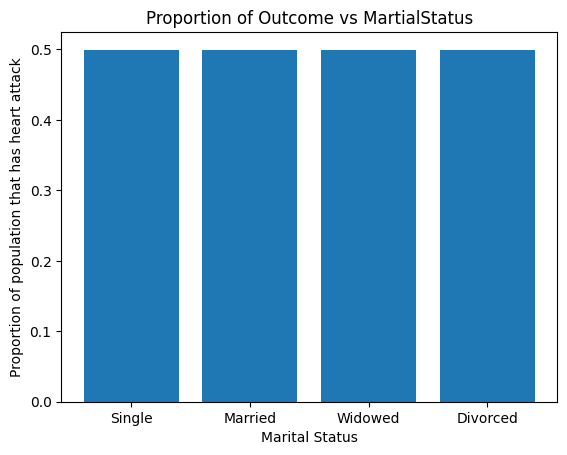

In [28]:
x_var = np.array(['Single', 'Married', 'Widowed', 'Divorced'])
y_var = np.array([single_proportion.iloc[1], married_proportion.iloc[1], widowed_proportion.iloc[1], divorced_proportion.iloc[1]])

plt.bar(x_var, y_var)
plt.title('Proportion of Outcome vs MartialStatus')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of population that has heart attack')
plt.show()

Since the p-value = 0.14 > (alpha = 0.05), we fail to reject the null hypothesis.